### 코랩 다운로드

In [1]:
! pip install git+https://github.com/yura52/rtdl.git
! pip install optuna

  Cloning https://github.com/yura52/rtdl.git to /tmp/pip-req-build-z037suie
  Running command git clone --filter=blob:none --quiet https://github.com/yura52/rtdl.git /tmp/pip-req-build-z037suie
  Resolved https://github.com/yura52/rtdl.git to commit bdc2fe52e0c28d0d15a3cf7d99ef94a452f23253
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

### 라이브러리 호출

In [2]:
import torch
import pandas as pd
import numpy as np

# ✅ Colab에서 GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("📌 사용 디바이스:", device)


📌 사용 디바이스: cuda


In [6]:
# ✅ 저장된 텐서 데이터 로드 (.pkl 파일)
import pickle

with open("VIF_split_data_ft_transformer.pkl", "rb") as f:
    X_train_tensor, X_valid_tensor, X_test_tensor, y_train_tensor, y_valid_tensor, y_test_tensor = pickle.load(f)

# ✅ GPU로 데이터 이동
X_train_tensor = X_train_tensor.to(device)
X_valid_tensor = X_valid_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_valid_tensor = y_valid_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)


In [7]:
# ✅ 범주형 변수 인덱스 및 값 매핑
X_train_df = pd.DataFrame(X_train_tensor.cpu().numpy())
categorical_indices = [] # 범주형 변수 저장
category_value_map = {}
# 라벨 인코딩되어 있는 데이터이기에 int, float형태, 그리고 값이 20개 이하인 것을 범주형
# 변수로 저장
for idx in X_train_df.columns:
    unique_values = X_train_df[idx].value_counts().index.tolist()
    if X_train_df[idx].dtype in ['int32', 'int64', 'float32', 'float64'] and len(unique_values) <= 20:
        categorical_indices.append(idx)
        category_value_map[idx] = unique_values

print("📌 범주형 변수 인덱스:", categorical_indices)



📌 범주형 변수 인덱스: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [8]:
from copy import deepcopy
# ✅ 적대적 공격 함수
# 범주형 값의 무작위 변화
def category_switch_attack_tensor(X_tensor, categorical_indices, category_value_map, num_switches=1, random_state=42):
    np.random.seed(random_state)
    X_np = X_tensor.cpu().numpy()
    X_adv = deepcopy(X_np)

    for i in range(X_adv.shape[0]):
        selected = np.random.choice(categorical_indices, size=min(num_switches, len(categorical_indices)), replace=False)
        for col in selected:
            current_val = X_adv[i, col]
            possible = list(set(category_value_map[col]) - {current_val})
            if possible:
                X_adv[i, col] = np.random.choice(possible)

    return torch.tensor(X_adv, dtype=X_tensor.dtype).to(X_tensor.device)


In [9]:
# ✅ 스위칭 1개 적용
X_train_adv = category_switch_attack_tensor(X_train_tensor, categorical_indices, category_value_map, num_switches=1)
X_valid_adv = category_switch_attack_tensor(X_valid_tensor, categorical_indices, category_value_map, num_switches=1)


In [11]:
with open("ADV&VIF_split_data_fn_transformer.pkl", "wb") as f:
        pickle.dump((X_train_adv, X_valid_adv, X_test_tensor,
                 y_train_tensor, y_valid_tensor, y_test_tensor), f)

In [ ]:
import pickle
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from rtdl import FTTransformer
import optuna

# ✅ GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ 모든 변수는 범주형 (라벨 인코딩 상태)
cat_indices = list(range(X_train_adv.shape[1]))  
cat_cardinalities = [
    int(X_train_adv[:, i].max().item()) + 1     
    for i in cat_indices
]

# ✅ 범주형만 분리하는 함수
def split_features(X_tensor):
    x_cat = X_tensor[:, cat_indices]
    return None, x_cat  # x_num은 없음

# ✅ DataLoader
train_dataset = TensorDataset(X_train_adv, y_train_tensor)  
valid_dataset = TensorDataset(X_valid_adv, y_valid_tensor)   

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=False)

# ✅ Optuna 목적 함수
def objective(trial):
    d_token = trial.suggest_categorical("d_token", [32, 64, 128])
    n_blocks = trial.suggest_int("n_blocks", 2, 6)
    n_heads = trial.suggest_categorical("n_heads", [2, 4, 8])
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    ffn_d_hidden = trial.suggest_categorical("ffn_d_hidden", [128, 256, 512])

    model = FTTransformer.make_baseline(
        n_num_features=0,                      # 수치형 없음
        cat_cardinalities=cat_cardinalities,   # 범주형 클래스 수 지정
        d_token=d_token,
        n_blocks=n_blocks,
        attention_dropout=dropout,
        ffn_d_hidden=ffn_d_hidden,
        ffn_dropout=dropout,
        residual_dropout=dropout,
        d_out=1
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    best_rmse = float("inf")
    patience = 10
    trigger_times = 0

    for epoch in range(80):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            _, x_cat = split_features(xb)
            pred = model(None, x_cat.to(device).long())
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # 검증
        model.eval()
        preds = []
        with torch.no_grad():
            for xb, _ in valid_loader:
                xb = xb.to(device)
                _, x_cat = split_features(xb)
                pred = model(None, x_cat.to(device).long())
                preds.append(pred.cpu().numpy())

        preds = np.vstack(preds)
        rmse = np.sqrt(np.mean((y_valid_tensor.cpu().numpy() - preds) ** 2))   # ⬅️ GPU 고려해 .cpu()

        if rmse < best_rmse:
            best_rmse = rmse
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                break

    return best_rmse

# ✅ Optuna 실행
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

# ✅ 결과 확인
print("Best trial:")
print(study.best_trial)


[I 2025-06-02 16:09:06,361] A new study created in memory with name: no-name-deb39b80-af87-4f81-b910-a70f99f4b8b3


Using device: cuda


[I 2025-06-02 16:18:41,755] Trial 0 finished with value: 0.00928332656621933 and parameters: {'d_token': 64, 'n_blocks': 6, 'n_heads': 4, 'dropout': 0.18461083843716591, 'ffn_d_hidden': 512}. Best is trial 0 with value: 0.00928332656621933.
[I 2025-06-02 16:24:31,457] Trial 1 finished with value: 0.009379222057759762 and parameters: {'d_token': 32, 'n_blocks': 5, 'n_heads': 8, 'dropout': 0.32337833611407996, 'ffn_d_hidden': 512}. Best is trial 0 with value: 0.00928332656621933.
[I 2025-06-02 16:30:32,199] Trial 2 finished with value: 0.009330421686172485 and parameters: {'d_token': 64, 'n_blocks': 4, 'n_heads': 8, 'dropout': 0.25255728504765235, 'ffn_d_hidden': 512}. Best is trial 0 with value: 0.00928332656621933.
[I 2025-06-02 16:42:37,939] Trial 3 finished with value: 0.009392506442964077 and parameters: {'d_token': 128, 'n_blocks': 6, 'n_heads': 4, 'dropout': 0.4874156178051334, 'ffn_d_hidden': 256}. Best is trial 0 with value: 0.00928332656621933.
[I 2025-06-02 16:50:04,718] Trial

Best trial:
FrozenTrial(number=0, state=1, values=[0.00928332656621933], datetime_start=datetime.datetime(2025, 6, 2, 16, 9, 6, 362038), datetime_complete=datetime.datetime(2025, 6, 2, 16, 18, 41, 755406), params={'d_token': 64, 'n_blocks': 6, 'n_heads': 4, 'dropout': 0.18461083843716591, 'ffn_d_hidden': 512}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'d_token': CategoricalDistribution(choices=(32, 64, 128)), 'n_blocks': IntDistribution(high=6, log=False, low=2, step=1), 'n_heads': CategoricalDistribution(choices=(2, 4, 8)), 'dropout': FloatDistribution(high=0.5, log=False, low=0.1, step=None), 'ffn_d_hidden': CategoricalDistribution(choices=(128, 256, 512))}, trial_id=0, value=None)


In [ ]:
fixed_params = {
    "d_token": 64,
    "n_blocks": 6,
    "n_heads": 4,
    "dropout": 0.18461083843716591,
    "ffn_d_hidden": 512
}

In [ ]:
def hparam_objective(trial):
    # 하이퍼파라미터 샘플링
    lr = trial.suggest_float("lr", 1e-4, 3e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [512, 1024, 2048])

    # 범주형 변수 인덱스 및 cardinalities (고정)
    cat_indices = list(range(X_train_adv.shape[1]))
    cat_cardinalities = [
        int(X_train_adv[:, i].max().item()) + 1
        for i in cat_indices
    ]

    # 모델 정의
    model = FTTransformer.make_baseline(
        n_num_features=0,
        cat_cardinalities=cat_cardinalities,
        d_token=fixed_params["d_token"],
        n_blocks=fixed_params["n_blocks"],
        attention_dropout=fixed_params["dropout"],
        ffn_d_hidden=fixed_params["ffn_d_hidden"],
        ffn_dropout=fixed_params["dropout"],
        residual_dropout=fixed_params["dropout"],
        d_out=1
    ).to(device)

    # 옵티마이저
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    # 배치 크기에 따른 DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=False)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=False)

    # 학습 루프
    best_rmse = float("inf")
    patience = 10
    trigger_times = 0

    for epoch in range(80):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            x_cat = xb[:, cat_indices].long()
            pred = model(None, x_cat)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # 검증
        model.eval()
        preds = []
        with torch.no_grad():
            for xb, _ in valid_loader:
                xb = xb.to(device)
                x_cat = xb[:, cat_indices].long()
                pred = model(None, x_cat)
                preds.append(pred.cpu().numpy())

        preds = np.vstack(preds)
        rmse = np.sqrt(np.mean((y_valid_tensor.cpu().numpy() - preds) ** 2))


        if rmse < best_rmse:
            best_rmse = rmse
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                break

    return best_rmse

study_hparam = optuna.create_study(direction="minimize")
study_hparam.optimize(hparam_objective, n_trials=5)  

print("Best trial:")
print(study_hparam.best_trial)


[I 2025-06-02 16:59:44,131] A new study created in memory with name: no-name-f8c9dcca-ba3f-470c-a1d1-790b04a58b2b
[I 2025-06-02 17:16:02,303] Trial 0 finished with value: 0.009363311342895031 and parameters: {'lr': 0.0011551468095722312, 'weight_decay': 0.009657899108623313, 'batch_size': 2048}. Best is trial 0 with value: 0.009363311342895031.
[I 2025-06-02 17:28:25,272] Trial 1 finished with value: 0.009597341530025005 and parameters: {'lr': 0.0014770590058152014, 'weight_decay': 0.00478996500029039, 'batch_size': 2048}. Best is trial 0 with value: 0.009363311342895031.
[I 2025-06-02 17:42:35,202] Trial 2 finished with value: 0.009553882293403149 and parameters: {'lr': 0.00028838988803365806, 'weight_decay': 0.006318059154128248, 'batch_size': 2048}. Best is trial 0 with value: 0.009363311342895031.
[I 2025-06-02 18:07:45,014] Trial 3 finished with value: 0.009289581328630447 and parameters: {'lr': 0.00022610258666503442, 'weight_decay': 0.009544484639969084, 'batch_size': 2048}. Bes

Best trial:
FrozenTrial(number=3, state=1, values=[0.009289581328630447], datetime_start=datetime.datetime(2025, 6, 2, 17, 42, 35, 203604), datetime_complete=datetime.datetime(2025, 6, 2, 18, 7, 45, 14064), params={'lr': 0.00022610258666503442, 'weight_decay': 0.009544484639969084, 'batch_size': 2048}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lr': FloatDistribution(high=0.003, log=True, low=0.0001, step=None), 'weight_decay': FloatDistribution(high=0.01, log=False, low=0.0, step=None), 'batch_size': CategoricalDistribution(choices=(512, 1024, 2048))}, trial_id=3, value=None)


In [1]:
fixed_params = {
    "d_token": 64,
    "n_blocks": 4,
    "n_heads": 4,
    "dropout": 0.1971837206675287,
    "ffn_d_hidden": 512
}

best_hparam = {
    "lr": 0.00022610258666503442,
    "weight_decay": 0.009544484639969084,
    "batch_size": 2048
}

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from rtdl import FTTransformer
from sklearn.metrics import mean_squared_error, r2_score

# ✅ 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ 데이터 병합 (train + valid)
X_final_tensor = torch.cat([X_train_adv, X_valid_adv], dim=0)
y_final_tensor = torch.cat([y_train_tensor, y_valid_tensor], dim=0)

train_dataset = TensorDataset(X_final_tensor, y_final_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=best_hparam["batch_size"], shuffle=True, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=best_hparam["batch_size"], shuffle=False, pin_memory=False)

# ✅ 범주형 인덱스 및 cardinalities 계산
cat_indices = list(range(X_final_tensor.shape[1]))
cat_cardinalities = [
    int(X_final_tensor[:, i].max().item()) + 1
    for i in cat_indices
]

# ✅ 모델 정의
model = FTTransformer.make_baseline(
    n_num_features=0,                         
    cat_cardinalities=cat_cardinalities,      #  범주형 cardinality 계산
    d_token=fixed_params["d_token"],
    n_blocks=fixed_params["n_blocks"],
    attention_dropout=fixed_params["dropout"],
    ffn_d_hidden=fixed_params["ffn_d_hidden"],
    ffn_dropout=fixed_params["dropout"],
    residual_dropout=fixed_params["dropout"],
    d_out=1
).to(device)


# ✅ 학습 준비
optimizer = torch.optim.AdamW(model.parameters(), lr=best_hparam["lr"], weight_decay=best_hparam["weight_decay"])
loss_fn = nn.MSELoss()

# ✅ 학습 루프
model.train()
for epoch in range(100):
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        x_cat = xb[:, cat_indices].long()
        optimizer.zero_grad()
        preds = model(None, x_cat)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[{epoch+1}/1000] Loss: {total_loss:.4f}")

# ✅ 테스트셋 예측
model.eval()
preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        x_cat = xb[:, cat_indices].long()
        pred = model(None, x_cat)
        preds.append(pred.cpu().numpy())

preds = np.vstack(preds)
y_test = y_test_tensor.cpu().numpy()

# ✅ 역정규화
y_min = 216.0
y_max = 165300000.0

preds_inverse = preds * (y_max - y_min) + y_min
y_test_inverse = y_test * (y_max - y_min) + y_min

# ✅ 성능 평가
mse = mean_squared_error(y_test_inverse, preds_inverse)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inverse, preds_inverse)

print(f"\n✅ 최종 RMSE: {rmse:,.2f}")
print(f"✅ 최종 R²: {r2:.5f}")

[1/1000] Loss: 1.7908
[2/1000] Loss: 0.1813
[3/1000] Loss: 0.0939
[4/1000] Loss: 0.0632
[5/1000] Loss: 0.0513
[6/1000] Loss: 0.0462
[7/1000] Loss: 0.0424
[8/1000] Loss: 0.0394
[9/1000] Loss: 0.0365
[10/1000] Loss: 0.0336
[11/1000] Loss: 0.0311
[12/1000] Loss: 0.0296
[13/1000] Loss: 0.0286
[14/1000] Loss: 0.0274
[15/1000] Loss: 0.0267
[16/1000] Loss: 0.0262
[17/1000] Loss: 0.0258
[18/1000] Loss: 0.0254
[19/1000] Loss: 0.0251
[20/1000] Loss: 0.0247
[21/1000] Loss: 0.0241
[22/1000] Loss: 0.0241
[23/1000] Loss: 0.0237
[24/1000] Loss: 0.0233
[25/1000] Loss: 0.0230
[26/1000] Loss: 0.0227
[27/1000] Loss: 0.0225
[28/1000] Loss: 0.0223
[29/1000] Loss: 0.0220
[30/1000] Loss: 0.0218
[31/1000] Loss: 0.0216
[32/1000] Loss: 0.0214
[33/1000] Loss: 0.0213
[34/1000] Loss: 0.0210
[35/1000] Loss: 0.0209
[36/1000] Loss: 0.0203
[37/1000] Loss: 0.0206
[38/1000] Loss: 0.0202
[39/1000] Loss: 0.0202
[40/1000] Loss: 0.0200
[41/1000] Loss: 0.0200
[42/1000] Loss: 0.0196
[43/1000] Loss: 0.0196
[44/1000] Loss: 0.01

In [ ]:
torch.save(model, "ADV_fttransformer_trained.pt")


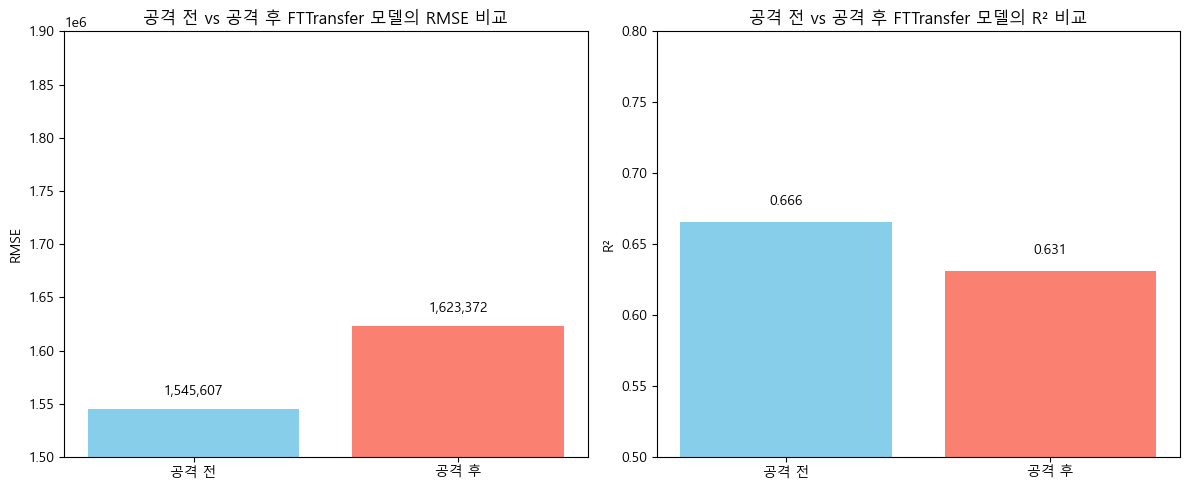

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ✅ 데이터
labels = ['공격 전', '공격 후']
rmse_values = [1545606.65, 1623371.64]
r2_values = [0.66571, 0.63123]
colors = ['skyblue', 'salmon']  # 공격 전/후 색상 지정

x = np.arange(len(labels))

# ✅ 시각화
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# ▶ RMSE 그래프
bars1 = axs[0].bar(labels, rmse_values, color=colors)
axs[0].set_title('공격 전 vs 공격 후 FTTransfer 모델의 RMSE 비교')
axs[0].set_ylabel('RMSE')
axs[0].set_ylim(1500000, 1900000)

# ▶ RMSE 막대 위 숫자
for bar in bars1:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, height + 10000, f"{height:,.0f}",
                ha='center', va='bottom', fontsize=10)

# ▶ R² 그래프
bars2 = axs[1].bar(labels, r2_values, color=colors)
axs[1].set_title('공격 전 vs 공격 후 FTTransfer 모델의 R² 비교')
axs[1].set_ylabel('R²')
axs[1].set_ylim(0.5, 0.8)

# ▶ R² 막대 위 숫자
for bar in bars2:
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.3f}",
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


# 추가 분석

In [12]:
from rtdl import FTTransformer
from torch.serialization import safe_globals
import torch

# ✅ 데이터 로딩
with open("ADV&VIF_split_data_fn_transformer.pkl", "rb") as f:
    X_train_adv, X_valid_tensor, X_test_adv, y_train_tensor, y_valid_tensor, y_test_tensor = pickle.load(f)

with safe_globals([FTTransformer]):
    ft_model = torch.load("ADV_fttransformer_trained.pt", weights_only=False, map_location=torch.device("cpu"))
ft_model.eval()

FTTransformer(
  (feature_tokenizer): FeatureTokenizer(
    (cat_tokenizer): CategoricalFeatureTokenizer(
      (embeddings): Embedding(90, 64)
    )
  )
  (cls_token): CLSToken()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0): ModuleDict(
        (attention): MultiheadAttention(
          (W_q): Linear(in_features=64, out_features=64, bias=True)
          (W_k): Linear(in_features=64, out_features=64, bias=True)
          (W_v): Linear(in_features=64, out_features=64, bias=True)
          (W_out): Linear(in_features=64, out_features=64, bias=True)
          (dropout): Dropout(p=0.1971837206675287, inplace=False)
        )
        (ffn): FFN(
          (linear_first): Linear(in_features=64, out_features=1024, bias=True)
          (activation): ReGLU()
          (dropout): Dropout(p=0.1971837206675287, inplace=False)
          (linear_second): Linear(in_features=512, out_features=64, bias=True)
        )
        (attention_residual_dropout): Dropout(p=0.19718372066752

In [17]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ✅ SMAPE 함수 정의
def smape(y_true, y_pred):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 100 * np.mean(diff)

# ✅ 역정규화 기준
y_min = 216.0
y_max = 165300000.0

# ✅ 예측
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ft_model.to(device)
ft_model.eval()
preds = []

cat_indices = list(range(X_test_tensor.shape[1]))
batch_size = 1024
n_samples = X_test_tensor.size(0)

with torch.no_grad():
    for i in range(0, n_samples, batch_size):
        xb = X_test_tensor[i:i+batch_size].to(device)
        x_cat = xb[:, cat_indices].long()
        pred = ft_model(None, x_cat)
        preds.append(pred.cpu().numpy())


# ✅ 연결 및 역정규화
y_pred = np.concatenate(preds).squeeze()
y_true = y_test_tensor.cpu().numpy().squeeze()

y_pred_inv = y_pred * (y_max - y_min) + y_min
y_true_inv = y_true * (y_max - y_min) + y_min

# ✅ 성능 지표 계산
mse = mean_squared_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_inv, y_pred_inv)
smp = smape(y_true_inv, y_pred_inv)
r2 = r2_score(y_true_inv, y_pred_inv)

# ✅ 출력
print("\n📊 FTTransformer 평가 결과 (적대적 훈련 기반)")
print(f"MSE:   {mse:,.2f}")
print(f"RMSE:  {rmse:,.2f}")
print(f"MAE:   {mae:,.2f}")
print(f"SMAPE: {smp:,.4f}%")
print(f"R²:    {r2:.5f}")




📊 FTTransformer 평가 결과 (적대적 훈련 기반)
MSE:   2,635,335,467,008.00
RMSE:  1,623,371.64
MAE:   427,002.44
SMAPE: 142.6570%
R²:    0.63123


In [18]:
import pandas as pd

# ✅ 저장할 지표 정리
result_df = pd.DataFrame([{
    "Model": "FTTransformer_ADV",  # 원하는 모델명 지정
    "MSE": mse,
    "RMSE": rmse,
    "MAE": mae,
    "SMAPE": smp,
    "R2": r2
}])


# ✅ CSV 저장
save_path = "adv_fttransforemr_results.csv"
result_df.to_csv(save_path, index=False)

print(f"📁 성능 지표 저장 완료 → {save_path}")


📁 성능 지표 저장 완료 → adv_fttransforemr_results.csv
